1. Загрузите данные за май 2016 года.

2. Проведите фильтрацию: удалите поездки с
нулевой длительностью
нулевым количеством пассажиров
нулевым расстоянием поездки по счётчику
координатами начала, не попадающими в прямоугольник Нью-Йорка
Можно придумать ещё какие-то критерии для фильтрации данных; тем не менее, не стоит применять дополнительные фильтры: начиная с четвёртой недели вам предстоит сравнивать качество ваших прогнозов с качеством прогнозов других слушателей, и, чтобы это сравнение было корректным, нужно, чтобы данные у всех были предобработаны одинаково.

3. Агрегируйте данные за май 2016 года по часам и областям (можно использовать функцию stats.binned_statistic_2d, с которой вы сталкивались в заданиях четвёртого курса). Не забудьте проверить, что идентификаторы, которые вы присваиваете ячейкам, соответствуют приложенному выше файлу.

4. Выведите первые строки полученной таблицы с указанием времени, идентификатора зоны и количества поездок.

5. Постройте график количества поездок жёлтого такси из ячейки, содержащей Empire State Building.

6. Посчитайте, сколько в мае 2016 было пар час-ячейка, для которых не было совершено ни одной поездки.

7. Загрузите ноутбук в форму ниже

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import binned_statistic_2d
import matplotlib.pyplot as plt
import datetime
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
ny_coordinates = [[ -74.25559, -73.70001],[40.91553, 40.49612]]
NY_west = ny_coordinates[0][0]
NY_east = ny_coordinates[0][1]
NY_north = ny_coordinates[1][0]
NY_south =  ny_coordinates[1][1]

## Загрузка данных

In [3]:
data = pd.read_csv('yellow_tripdata_2016-05.csv', header=0, skipinitialspace=True,
                  parse_dates=[1,2],
                  date_parser= lambda x: datetime.datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))

In [4]:
data.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RatecodeID,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
0,1,2016-05-01,2016-05-01 00:17:31,1,3.60,-73.985901,40.768040,1,N,-73.983986,40.730099,1,15.0,0.5,0.5,1.50,0.0,0.3,17.80
1,2,2016-05-01,2016-05-01 00:07:31,1,1.68,-73.991577,40.744751,1,N,-73.975700,40.765469,1,7.5,0.5,0.5,0.88,0.0,0.3,9.68
2,2,2016-05-01,2016-05-01 00:07:01,6,1.09,-73.993073,40.741573,1,N,-73.980995,40.744633,1,6.5,0.5,0.5,1.56,0.0,0.3,9.36
3,2,2016-05-01,2016-05-01 00:19:47,1,4.21,-73.991943,40.684601,1,N,-74.002258,40.733002,1,17.0,0.5,0.5,3.66,0.0,0.3,21.96
4,2,2016-05-01,2016-05-01 00:06:39,1,0.56,-74.005280,40.740192,1,N,-73.997498,40.737564,1,6.0,0.5,0.5,1.46,0.0,0.3,8.76


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11836853 entries, 0 to 11836852
Data columns (total 19 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   VendorID               int64         
 1   tpep_pickup_datetime   datetime64[ns]
 2   tpep_dropoff_datetime  datetime64[ns]
 3   passenger_count        int64         
 4   trip_distance          float64       
 5   pickup_longitude       float64       
 6   pickup_latitude        float64       
 7   RatecodeID             int64         
 8   store_and_fwd_flag     object        
 9   dropoff_longitude      float64       
 10  dropoff_latitude       float64       
 11  payment_type           int64         
 12  fare_amount            float64       
 13  extra                  float64       
 14  mta_tax                float64       
 15  tip_amount             float64       
 16  tolls_amount           float64       
 17  improvement_surcharge  float64       
 18  total_amount        

In [6]:
regions = pd.read_csv('regions.csv', sep=';')
regions.head()

,region,west,east,south,north
0,1,-74.25559,-74.244478,40.496120,40.504508
1,2,-74.25559,-74.244478,40.504508,40.512896
2,3,-74.25559,-74.244478,40.512896,40.521285
3,4,-74.25559,-74.244478,40.521285,40.529673
4,5,-74.25559,-74.244478,40.529673,40.538061


## Фильтруем данные

In [7]:
data = data[(data.tpep_pickup_datetime != data.tpep_dropoff_datetime)&
            (data.passenger_count > 0)&
            (data.trip_distance > 0)&
            (data.pickup_latitude <= NY_north)&
            (data.pickup_latitude >= NY_south)&
            (data.pickup_longitude<= NY_east)&
            (data.pickup_longitude>= NY_west)
           ]

In [8]:
len(data)

11626521

In [9]:
data.tpep_pickup_datetime = data.tpep_pickup_datetime.apply(lambda x: x.replace(minute=0, second=0))

In [10]:
print(data.tpep_pickup_datetime)

0          2016-05-01 00:00:00
1          2016-05-01 00:00:00
2          2016-05-01 00:00:00
3          2016-05-01 00:00:00
4          2016-05-01 00:00:00
                   ...        
11836837   2016-05-31 23:00:00
11836838   2016-05-31 23:00:00
11836839   2016-05-31 23:00:00
11836840   2016-05-31 23:00:00
11836841   2016-05-19 03:00:00
Name: tpep_pickup_datetime, Length: 11626521, dtype: datetime64[ns]


## Агрегируем данные

In [11]:
# Берем поездки и считываем функцией binned_stat для получения данных по поездкам
def trips_2d_stat (x,y, marked_regions, crd = [-74.25559, -73.70001, 40.49612, 40.91553]):
    west,east,south,north=crd
    stat = binned_statistic_2d(x,y, np.arange(len(x)), statistic='count',
                              range=[[west,east],[south,north]],
                              bins=[marked_regions.west.append(marked_regions.east).unique(),
                                   marked_regions.south.append(marked_regions.north).unique()],
                              expand_binnumbers=True)
    return(stat.statistic.ravel())

## Поиск и присваивание секторов. Их сверка

In [12]:
#function for finding long-latit region
def reg_l_l(reg_data, data):
    print(data)
    return((reg_data.north >= data.pickup_latitude)& # Ю или равен С
          (reg_data.south <= data.pickup_latitude)&  # С или равен Ю
          (reg_data.west  <= data.pickup_longitude)& # В или равен З
          (reg_data.east  >=  data.pickup_longitude))# З или равен В
# делим сектора
def long(val, west, east):
#     return(abs(np.ceil(((val-west)*50)/(east-west))))
    return(np.ceil(((val-west)*50)/(east-west)))
def lat(val, north, south):
#     return(abs(np.ceil(((val-south)*50)/(north-south))))
    return(np.ceil(((val-south)*50)/(north-south)))
def sector(latitude, longitude, north, south, east, west):
    return((long(longitude, west, east) -1)*50 + lat(latitude, north, south))
assert regions[reg_l_l(regions, data.iloc[0])].region.values[0] == sector(data.iloc[0].pickup_latitude, data.iloc[0].pickup_longitude, NY_north, NY_south, NY_east, NY_west),'Result from *finding sector* function isn`t equal'
print('Checking complete. All is ok.')

VendorID                                   1
tpep_pickup_datetime     2016-05-01 00:00:00
tpep_dropoff_datetime    2016-05-01 00:17:31
passenger_count                            1
trip_distance                            3.6
pickup_longitude                    -73.9859
pickup_latitude                       40.768
RatecodeID                                 1
store_and_fwd_flag                         N
dropoff_longitude                    -73.984
dropoff_latitude                     40.7301
payment_type                               1
fare_amount                               15
extra                                    0.5
mta_tax                                  0.5
tip_amount                               1.5
tolls_amount                               0
improvement_surcharge                    0.3
total_amount                            17.8
Name: 0, dtype: object
Checking complete. All is ok.


In [13]:
data['region'] = sector(data.pickup_latitude, data.pickup_longitude, NY_north, NY_south, NY_east, NY_west)

In [14]:
data.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RatecodeID,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,region
0,1,2016-05-01,2016-05-01 00:17:31,1,3.60,-73.985901,40.768040,1,N,-73.983986,40.730099,1,15.0,0.5,0.5,1.50,0.0,0.3,17.80,1233.0
1,2,2016-05-01,2016-05-01 00:07:31,1,1.68,-73.991577,40.744751,1,N,-73.975700,40.765469,1,7.5,0.5,0.5,0.88,0.0,0.3,9.68,1180.0
2,2,2016-05-01,2016-05-01 00:07:01,6,1.09,-73.993073,40.741573,1,N,-73.980995,40.744633,1,6.5,0.5,0.5,1.56,0.0,0.3,9.36,1180.0
3,2,2016-05-01,2016-05-01 00:19:47,1,4.21,-73.991943,40.684601,1,N,-74.002258,40.733002,1,17.0,0.5,0.5,3.66,0.0,0.3,21.96,1173.0
4,2,2016-05-01,2016-05-01 00:06:39,1,0.56,-74.005280,40.740192,1,N,-73.997498,40.737564,1,6.0,0.5,0.5,1.46,0.0,0.3,8.76,1130.0


##  Собираем по часам и датам

In [15]:
def hour(date):
    date = date.replace(day = 1, hour = 0, minute = 0, second =0)
    month_target = date.month
    month = date.month
    result =[]
    while month_target == month:
        result.append(date)
        date = date + datetime.timedelta(hours = 1)
        month = date.month
    return(result)

In [16]:
hours = hour(data.tpep_pickup_datetime[0])

In [17]:
for i in hours:
    values = np.zeros((regions.shape[0],))
    regions[i] = values

In [18]:
# stats at trips
for i in set(data.tpep_pickup_datetime):
    chunk = data[data.tpep_pickup_datetime == i]
    x = np.array(chunk.pickup_longitude)
    y = np.array(chunk.pickup_latitude)
    regions[i] = np.array(regions[i]) + trips_2d_stat(x,y,regions)

In [19]:
clmns = [0] + list(range(regions.shape[1]))[:10]
regions.iloc[0:2, clmns]

,region,region,west,east,south,north,2016-05-01 00:00:00,2016-05-01 01:00:00,2016-05-01 02:00:00,2016-05-01 03:00:00,2016-05-01 04:00:00
0,1,1,-74.25559,-74.244478,40.496120,40.504508,0.0,0.0,0.0,0.0,0.0
1,2,2,-74.25559,-74.244478,40.504508,40.512896,0.0,0.0,0.0,0.0,0.0


In [20]:
regions.iloc[:, [0, 5, 6]]

,region,2016-05-01 00:00:00,2016-05-01 01:00:00
0,1,0.0,0.0
1,2,0.0,0.0
2,3,0.0,0.0
3,4,0.0,0.0
4,5,0.0,0.0
...,...,...,...
2495,2496,0.0,0.0
2496,2497,0.0,0.0
2497,2498,0.0,0.0
2498,2499,0.0,0.0


## ESB
Постройка графика количества поездок жёлтого такси из ячейки, содержащей Empire State Building. Координаты ESB взяты с сайта: https://www.gps-latitude-longitude.com/gps-coordinates-of-empire-state-building-new-york

In [21]:
#Longitude of Empire State Building New York: -73.985664
#Latitude of Empire State Building New York: 40.748441
ESB_long = -73.985664
ESB_lat  =  40.748441

In [22]:
ESB_reg = int(sector(ESB_lat, ESB_long, NY_north, NY_south, NY_east, NY_west))
print('Empire State Building stay at',ESB_reg, 'region')

Empire State Building stay at 1231 region


Text(0, 0.5, 'Trips')

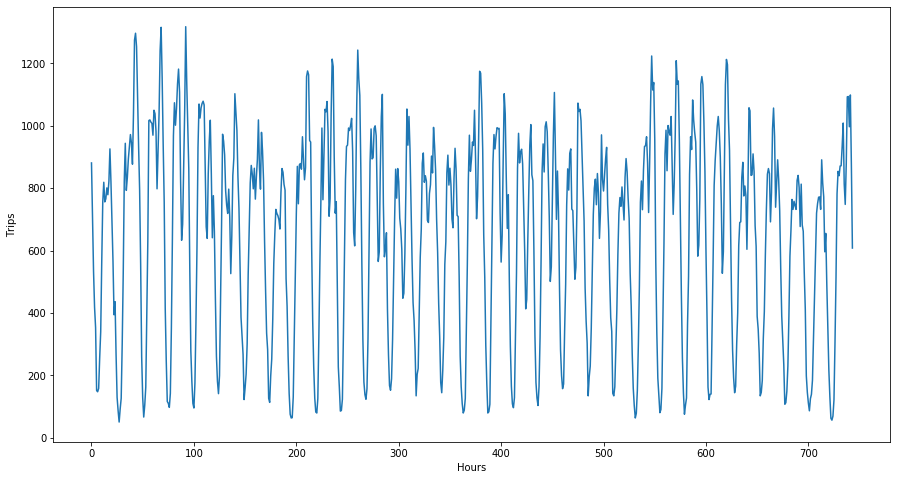

In [23]:
trips = np.array(regions.iloc[ESB_reg-1, 5:])
hours = list(range(len(trips)))
plt.figure(figsize=(15,8))
plt.plot(hours, trips)
#plt.axes().set_aspect('auto')
plt.xlabel('Hours')
plt.ylabel('Trips')

## Количество пар час ячейка с 0 поездок в мае 2016 

In [24]:
N_zeros = np.array(regions.iloc[:,5:])
zeros = N_zeros.size - np.count_nonzero(N_zeros)

In [25]:
print(N_zeros.size, 'Количество пар ячеек')
print(zeros, "Из них 0")

1860000 Количество пар ячеек
1718238 Из них 0


In [26]:
import pickle
with open('data.pkl','wb') as fid:
    pickle.dump(ag_.statistic, fid)
with open('regions.pkl','wb') as fid:
    pickle.dump(ag_1.statistic, fid)

NameError: name 'ag_' is not defined

In [ ]:
with open('data.pkl','wb') as fid:
    pickle.dump(ag_.statistic, fid)